In [43]:
# tested with env: unsup_ctrl_2

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import nltk
from datasets import load_dataset
from transformers import AutoTokenizer
import multiprocessing as mp

from math import exp, log, floor
import random
from itertools import islice

from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import process_map

In [59]:
n_workers = 2 * mp.cpu_count()
print(f"{n_workers} workers are available")
data_dir = Path('scratch/books1/raw')
file = 'train.txt'
sample_size = 1_000_000

# tokenizer = AutoTokenizer.from_pretrained('scratch/bookcorpus/tok/')
nltk.download("punkt")
sentence_tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")

16 workers are available


[nltk_data] Downloading package punkt to
[nltk_data]     /home/cluster/tkew/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [60]:
def reservoir_sample(iterable, k=1, seed=42):
    """Select k items uniformly from iterable.

    Returns the whole population if there are k or fewer items

    from https://bugs.python.org/issue41311#msg373733
    via https://stackoverflow.com/questions/22258491/read-a-small-random-sample-from-a-big-csv-file-into-a-python-data-frame
    """
    iterator = iter(iterable)
    values = list(islice(iterator, k))
    random.seed(seed)
    W = exp(log(random.random())/k)
    while True:
        # skip is geometrically distributed
        skip = floor(log(random.random())/log(1-W))
        selection = list(islice(iterator, skip, skip+1))
        if selection:
            values[random.randrange(k)] = selection[0]
            W *= exp(log(random.random())/k)
        else:
            return values

def sample_file(filepath, k, has_header=False):
    with open(filepath, 'r', encoding='utf8') as f:
        if has_header:
            header = next(f)
        result = reservoir_sample(f, k)
        result = [l.strip() for l in result] # remove newline chars
    return result

lines = sample_file(data_dir / file, sample_size)

In [61]:
# vocab
vocab = Counter()
for line in lines:
    vocab.update(line.split())
print(f'Tokens in vocab: {len(vocab)}')
print(f'Total token count: {sum(vocab.values())}')
mc = vocab.most_common()
print(f'Most common tokens: {mc[:10]}')
print(f'Least common tokens: {mc[-10:]}')

Tokens in vocab: 472285
Total token count: 13510551
Most common tokens: [('the', 671701), ('to', 374102), ('and', 361913), ('of', 298101), ('a', 272316), ('I', 188295), ('in', 181953), ('was', 167227), ('that', 128148), ('his', 123951)]
Least common tokens: [('split-rail', 1), ("Kora's", 1), ('Mould', 1), ('wilt.', 1), ('26-Jul-04', 1), ('Mosul', 1), ('Birds?', 1), ("Ralegh's", 1), ('Frenchy', 1), ('terrified-into-silence', 1)]


In [62]:
df = pd.DataFrame({'text': lines})
df

,text
0,Obriega wasn't so sure about that.
1,It is a merging of traditions and kin.
2,"Griffin carried Pet in his arms, her body and ..."
3,"Nhẹ hơn, có những đứa trách ông ướm hương lên ..."
4,"""Sometimes...I have these; well what would you..."
...,...
999995,"Gilbert was sleeping on the ground, snoring."
999996,Winking at Trumpet as he slipped past Ralegh's...
999997,I could only imagine what it would have done t...
999998,The Frenchy got up after moi and wiped a littl...


In [63]:
batch = round(len(df)/n_workers)
def count_tokens(text):
    return len(text.split())

df['length'] = process_map(count_tokens, df['text'], max_workers=n_workers, chunksize=batch)

100%|██████████| 1000000/1000000 [00:00<00:00, 1298454.47it/s]


In [64]:
print(df['length'].describe())

count    1000000.000000
mean          13.510551
std           10.081512
min            1.000000
25%            6.000000
50%           11.000000
75%           18.000000
max          760.000000
Name: length, dtype: float64


Text(0.5, 0, '# tokens')

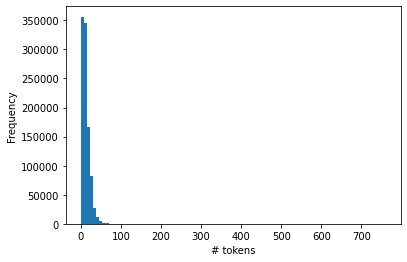

In [65]:
ax = df['length'].plot(kind='hist', bins=100)
ax.set_xlabel('# tokens')

In [66]:
# def count_tokens(example):
#     return {'#tokens': len(example["text"].split())}

# def count_sentences(example):
#     return {'#sents': len(sentence_tokenizer.tokenize(example["text"]))}

# def collect_vocab(data):
#     vocab = Counter()
#     for item in data:
#         vocab.update(item.split())
#     print(f'length of vocab: {len(vocab)}')
#     print(f'most common: {vocab.most_common(20)}')
#     return vocab


# dataset = dataset.map(count_tokens)
# dataset = dataset.map(count_sentences)
# vocab = collect_vocab(dataset['text'])

# df = dataset.to_pandas()
# df

# df['#tokens'].plot(kind='hist', bins=50)